In [5]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
#맷플랏립 그래프 주피터에서 바로 출력하기
import seaborn as sns

from scipy import stats
from scipy.stats import t, norm, chi2, chi2_contingency
import re
import time

from matplotlib import rc
rc('font', family='Malgun Gothic')      #한글 폰트설정
plt.rcParams['axes.unicode_minus']=False      #마이너스 부호 출력 설정

In [6]:
from sklearn.datasets import load_iris
from sklearn import datasets

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

In [7]:
from sklearn import tree
from sklearn.datasets import make_classification

from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

import xgboost    #1.7.5버전
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer

from hyperopt import hp
from hyperopt import fmin, tpe, Trials
from hyperopt import STATUS_OK

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_boston

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

In [8]:
df = pd.read_csv(r'D:\hmkd1\m1_programming\[8] 머신러닝\bike_train.csv')
print(df.shape)
df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [10]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [11]:
# 데이터 타입 변경
df.datetime = df.datetime.apply(pd.to_datetime)

# 년, 월, 일, 시간 추출
df['year'] = df.datetime.apply(lambda x: x.year)
df['month'] = df.datetime.apply(lambda x: x.month)
df['day'] = df.datetime.apply(lambda x: x.day)
df['hour'] = df.datetime.apply(lambda x: x.hour)

df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [12]:
df.drop(['datetime','casual','registered'], axis=1, inplace=True)

In [13]:
df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


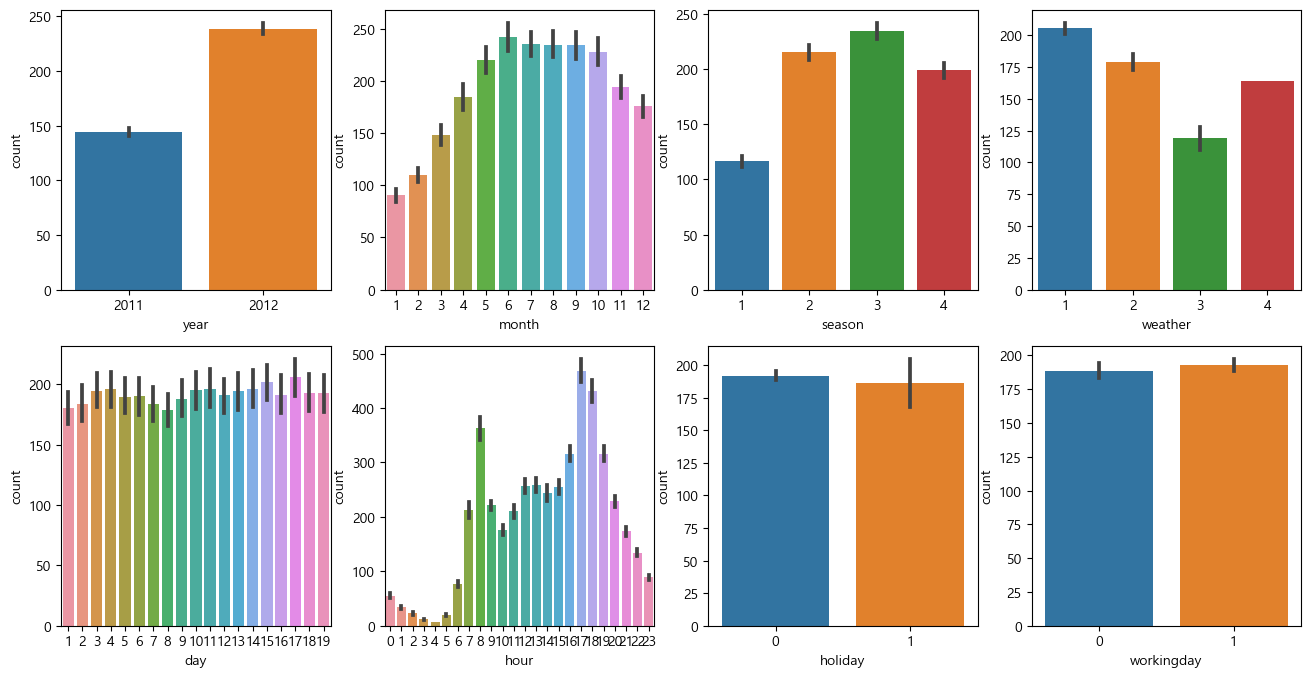

In [14]:
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
cat_feature = ['year','month','season','weather','day','hour','holiday','workingday']

for i, feat in enumerate(cat_feature):
    row=int(i/4); col=i%4
    sns.barplot(x=feat, y='count', data=df, ax=axs[row][col])   #각 칼럼별 count 그래프

In [15]:
# 평가함수: RMSLE, RMSE, MAE

# 그냥 로그변환은 nan값 등 오류가 발생할 수 있으므로
# log() 대신 log1p() 사용
def evaluate_regr(ytest, pred):
    squared_error = (np.log1p(ytest)-np.log1p(pred)) **2
    rmsle = np.sqrt(np.mean(squared_error))
    
    rmse = np.sqrt(mean_squared_error(ytest, pred))
    
    mae = mean_absolute_error(ytest, pred)
    
    print(f'''RMSLE: {rmsle:.3f}
RMSE: {rmse:.3f}
MAE: {mae:.3f}''')

In [16]:
# 로그변환, 피처인코딩 전 모델 학습/예측/평가
xdf = df.drop('count', axis=1)
ydf = df['count']

xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf, 
                            random_state=0, test_size=0.3)
lrr = LinearRegression()
lrr.fit(xtrain, ytrain)
pred = lrr.predict(xtest)

evaluate_regr(ytest, pred)

RMSLE: 1.165
RMSE: 140.900
MAE: 105.924


In [19]:
def get_error_data(ytest, pred):
    result_df = pd.DataFrame(ytest.values, columns=['실제count'])
    result_df['예측count'] = np.round(pred)
    result_df['오차'] = np.abs(result_df['실제count']-result_df['예측count'])
    
    sort_df = result_df.sort_values('오차', ascending=False)
    return sort_df   #오차 큰 순으로 정렬된 DF

sort_df = get_error_data(ytest, pred)
sort_df.head(5)

,실제count,예측count,오차
1618,890,322.0,568.0
3151,798,241.0,557.0
966,884,327.0,557.0
412,745,194.0,551.0
2817,856,310.0,546.0


<AxesSubplot:>

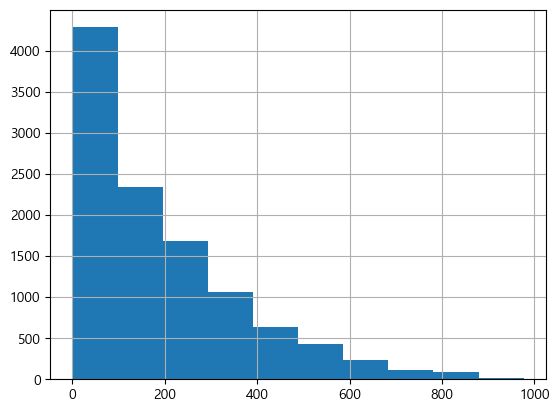

In [20]:
ydf.hist()

<AxesSubplot:>

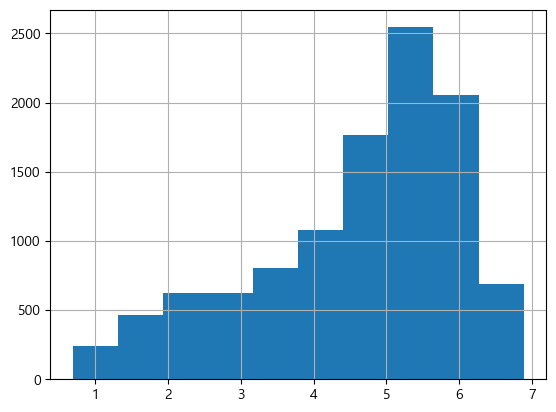

In [21]:
y_log = np.log1p(ydf)
y_log.hist()

In [23]:
ydf_log = np.log1p(ydf)   #로그변환 후 학습/검증 데이터셋 분할
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf_log,
                          test_size=0.3, random_state=0)
lrr = LinearRegression()
lrr.fit(xtrain,ytrain)
pred = lrr.predict(xtest)

ytest_expm = np.expm1(ytest)  #로그변환 된 데이터를 다시 원래 스케일로 환원
pred_expm = np.expm1(pred)   #로그변환 데이터를 기반으로 한 예측값도 환원

evaluate_regr(ytest_expm, pred_expm)

RMSLE: 1.017
RMSE: 162.594
MAE: 109.286


<AxesSubplot:>

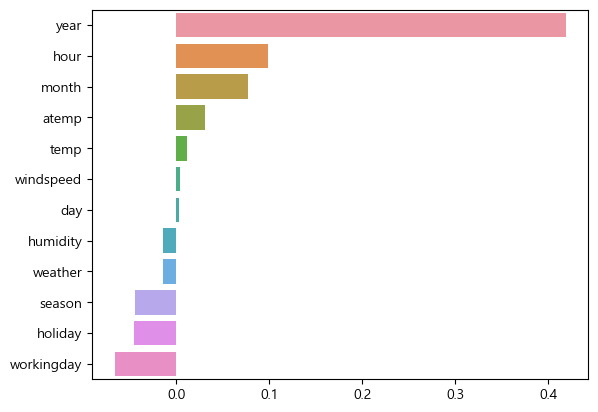

In [26]:
coef = pd.Series(lrr.coef_, index=xdf.columns)   #coef_: 선형회귀 계수(높을수록 예측결과에 큰 영향)
coef_sort = coef.sort_values(ascending=False)

sns.barplot(x=coef_sort, y=coef_sort.index)

In [27]:
# 원핫 인코딩
feature_list = ['year','month','day','hour','holiday','workingday','season','weather']
xdf_onehot = pd.get_dummies(xdf, columns=feature_list)

## 5.9 Regression 실습 - Bike Sharing Demand
### 데이터 클렌징 및 가공

In [ ]:
bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

In [ ]:
bike_df.info()

In [ ]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

In [ ]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

In [ ]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month','season','weather','day', 'hour', 'holiday','workingday']
# cat_features에 있는 모든 칼럼별로 개별 칼럼값에 따른 count의 합을 barplot으로 시각화
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

In [ ]:
# log값 변환 시 NaN등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def def_rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    
    squared_error = (log_y - log_pred)**2   #오차(실제값-예측값)의 제곱
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# mean_square_error(): RMSE 계산
def def_rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 계산 
def evaluate_regr(y, pred):
    rmsle = def_rmsle(y, pred)
    rmse = def_rmse(y, pred)
    mae = mean_absolute_error(y, pred)   # MAE: mean_absolute_error()
    print(f'RMSLE: {rmsle:.3f}, RMSE: {rmse:.3F}, MAE: {mae:.3F}')

### 로그 변환, 피처 인코딩, 모델 학습/예측/평가 

In [ ]:
# 로그 변환, 피처 인코딩 전 원래의 평가 수치들
y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                        test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

In [ ]:
def get_top_error_data(y_test, pred, n_tops=5):
    # 실제 대여횟수(count)와 예측값을 서로 비교 할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])
    
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력
    sort_rdf = result_df.sort_values('diff', ascending=False)
    print(sort_rdf.head(n_tops))
    return sort_rdf
    
sort_rdf = get_top_error_data(y_test,pred,n_tops=5)
sort_rdf.head(5)

In [ ]:
y_target.hist()

In [ ]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [ ]:
# 타깃 칼럼(count값) y_target를 로그변환(log1p)
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, 
                          y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# np.expm1: 환원(Log변환된 테스트셋(y_test)값을 다시 원래 scale로 변환)
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log변환된 y_target을 기반으로 학습해 예측되었으므로 
# 다시 exmpl으로 scale변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)   # MSE, RMSE, RMSLE 계산 사용자함수

In [ ]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
#lr_reg.coef_: 선형회귀 계수(가중치) -> 높을수록 예측결과에 큰 영향을 미침
coef_sort = coef.sort_values(ascending=False)

sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')
# plt.savefig: 그래프 그림으로 저장

In [ ]:
# 원핫 인코딩
features_name = ['year','month','day','hour','holiday','workingday','season','weather']
X_features_ohe = pd.get_dummies(X_features, columns=features_name)

In [ ]:
# 모델과 학습/테스트 데이터 셋 입력 -> 성능 평가수치 반환 함수
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    if is_expm1:   #로그변환을 여부에 따라 환원
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
        
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)   # MSE, RMSE, RMSLE 계산 사용자함수
    
#########################################################################

# 원-핫 인코딩 후 데이터 세트 기반으로, 학습/예측 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, 
                        y_target_log, test_size=0.3, random_state=0)

# 모델별 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test,is_expm1=True)

In [ ]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)   #각 변수의 계수값
coef_sort = coef.sort_values(ascending=False)[:20]   #큰 순서대로 20개(예측 결과에 영향이 큰 순)

sns.barplot(x=coef_sort.values, y=coef_sort.index)
# 원핫 인코딩을 해서 각 각각의 달, 날짜 등이 서로 다른 칼럼들로 나옴

In [ ]:
# 로그변환, 원핫 인코딩 후 평가 수치들
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost -> DataFrame은 버전에 따라 오류 발생(ndarray로 변환하기)
    get_model_predict(model, X_train.values, X_test.values, 
                y_train.values, y_test.values, is_expm1=True)